# Setup

In [1]:
# General libraries
import pandas as pd
import numpy as np
import warnings
import lightgbm
import gc
import os

# Plots
from matplotlib import pyplot as plt

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_regression

# Statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

# Forecaster
from lightgbm import LGBMRegressor

# Multiprocessing
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from functools import partial

# Plots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython import display
from time import sleep
from math import ceil

# Cuda
import torch

# Pd options
pd.set_option('display.max_columns', None)

In [2]:
# Suppress warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Suppress the specific PerformanceWarning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [3]:
# Get the number of available CPUs
num_cpus = os.cpu_count()

# Show
print(num_cpus)

12


In [4]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
else:
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


# Directory

In [5]:
# Set cd to parent directory
os.chdir("/Users/ignasipascual/GitHub/LightGBM-Forecaster")
cwd = os.getcwd()
print("Current Working Directory:", cwd)

Current Working Directory: /Users/ignasipascual/GitHub/LightGBM-Forecaster


In [6]:
# Set source
source = 'local'

# Print files in directory
if source == 'gdrive':
    # Use directory from gdrive
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Forecasting')
    print("Listing files from Google Drive 'Forecasting' directory:")
    # Drivers for cuda
    !mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
    # Google colab options
    # Google
    from google.colab import output
    output.no_vertical_scroll()
else:
    print("Listing files from the current local directory:")

# List files in the specified directory
files = os.listdir()

# Print each file
for file in files:
    print(file)

Listing files from the current local directory:
.DS_Store
LICENSE
requirements.txt
utils
docs
README.md
.gitignore
submissions
.git
data
notebooks


# Assets

## Import assets

In [7]:
# Import assets
from utils.forecaster import Forecaster
from utils.evaluator import Evaluator
from utils.auxiliar import *

# Load data

In [8]:
# Create the filename with the phase appended
file_name = f'Data/df_backtesting.csv'

# Read the CSV file
df_input = pd.read_csv(file_name)

# Show
df_input.head()

client  warehouse  product    id_column        date  sales  price  \
0       1        151     1241   1/151/1241  2020-07-06    0.0    NaN   
1       1        182    13789  1/182/13789  2020-07-06    0.0    NaN   
2       1        182     3145   1/182/3145  2020-07-06    0.0    NaN   
3       1        182     3864   1/182/3864  2020-07-06    0.0    NaN   
4       1        182     3971   1/182/3971  2020-07-06    0.0    NaN   

   filled_sales  filled_price      cutoff sample  feature_client  \
0           0.0           NaN  2023-09-04  train               0   
1           0.0           NaN  2023-09-04  train               0   
2           0.0           NaN  2023-09-04  train               0   
3           0.0           NaN  2023-09-04  train               0   
4           0.0           NaN  2023-09-04  train               0   

   feature_warehouse  feature_product  feature_id_column  feature_periods  \
0                  7              426                  2              0.0   
1                  8              677                 14              0.0   
2                  8             1104                 16              0.0   
3                  8             1223                 19              0.0   
4                  8             1243                 20              0.0   

   feature_periods_expanding  feature_periods_sqrt  feature_year  \
0                        0.0                   0.0          2020   
1                        0.0                   0.0          2020   
2                        0.0                   0.0          2020   
3                        0.0                   0.0          2020   
4                        0.0                   0.0          2020   

   feature_quarter  feature_month  feature_week  \
0                3              7            28   
1                3              7            28   
2                3              7            28   
3                3              7            28   
4                3              7            28   

   feature_weeks_until_next_end_of_quarter  feature_weeks_until_end_of_year  \
0                                       12                               25   
1                                       12                               25   
2                                       12                               25   
3                                       12                               25   
4                                       12                               25   

   feature_months_until_next_end_of_quarter  feature_months_until_end_of_year  \
0                                         2                                 5   
1                                         2                                 5   
2                                         2                                 5   
3                                         2                                 5   
4                                         2                                 5   

   filled_sales_ma_4  filled_sales_ma_13  filled_price_ma_4  \
0                0.0                 0.0                NaN   
1                0.0                 0.0                NaN   
2                0.0                 0.0                NaN   
3                0.0                 0.0                NaN   
4                0.0                 0.0                NaN   

   filled_price_ma_13  filled_sales_min_13  filled_sales_max_13  \
0                 NaN                  0.0                  0.0   
1                 NaN                  0.0                  0.0   
2                 NaN                  0.0                  0.0   
3                 NaN                  0.0                  0.0   
4                 NaN                  0.0                  0.0   

   filled_price_min_13  filled_price_max_13  feature_filled_sales_lag_13  \
0                  NaN                  NaN                          NaN   
1                  NaN                  NaN                          NaN   
2         

## Statistics

In [9]:
# Find duplicate column names
duplicate_columns = df_input.columns[df_input.columns.duplicated()].tolist()

# Show
print("Duplicate column names:", duplicate_columns)

Duplicate column names: []


In [10]:
# Check if any column is completely filled with NaN values
na_columns = df_input.columns[df_input.isna().all()].tolist()

# Show
print("Columns full of NaN values:", na_columns)

Columns full of NaN values: []


In [11]:
# Show data types
df_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2724608 entries, 0 to 2724607
Data columns (total 66 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   client                                      int64  
 1   warehouse                                   int64  
 2   product                                     int64  
 3   id_column                                   object 
 4   date                                        object 
 5   sales                                       float64
 6   price                                       float64
 7   filled_sales                                float64
 8   filled_price                                float64
 9   cutoff                                      object 
 10  sample                                      object 
 11  feature_client                              int64  
 12  feature_warehouse                           int64  
 13  feature_product            

# Forecasting model

## Features

In [12]:
# Automatically find all feature columns containing 'feature' in their names
features = [col for col in df_input.columns if "feature" in col]

# Create default trainining group
df_input['training_group'] = 1

# Show
features

['feature_client',
 'feature_warehouse',
 'feature_product',
 'feature_id_column',
 'feature_periods',
 'feature_periods_expanding',
 'feature_periods_sqrt',
 'feature_year',
 'feature_quarter',
 'feature_month',
 'feature_week',
 'feature_weeks_until_next_end_of_quarter',
 'feature_weeks_until_end_of_year',
 'feature_months_until_next_end_of_quarter',
 'feature_months_until_end_of_year',
 'feature_filled_sales_lag_13',
 'feature_filled_sales_lag_52',
 'feature_filled_price_lag_13',
 'feature_filled_price_lag_52',
 'feature_filled_sales_ma_4_lag_13',
 'feature_filled_sales_ma_4_lag_52',
 'feature_filled_price_ma_4_lag_13',
 'feature_filled_price_ma_4_lag_52',
 'feature_filled_sales_ma_13_lag_13',
 'feature_filled_sales_ma_13_lag_52',
 'feature_filled_price_ma_13_lag_13',
 'feature_filled_price_ma_13_lag_52',
 'feature_filled_sales_min_13_lag_13',
 'feature_filled_sales_min_13_lag_52',
 'feature_filled_sales_max_13_lag_13',
 'feature_filled_sales_max_13_lag_52',
 'feature_filled_sales_c

In [13]:
# Number of features
print("Number of features:", len(features))

Number of features: 42


## Hyperparameters

In [14]:
# Define the default LightGBM hyperparameters
default_lgb_hyperparams = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'n_estimators': 2500,
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1,
    'seed': 42
}

# Define the expanded LightGBM parameters for grid search
hyperparameter_grid = {
    # Core Parameters
    'objective': ['regression'],
    'boosting_type': ['gbdt', 'dart'],
    'metric': ['rmse', 'mae'],
    'n_estimators': [1000, 2000, 3000],
    'learning_rate': [0.01, 0.05, 0.10],
    'num_leaves': [16, 31, 48],
    'max_depth': [4, 8, 12],
    # Control Overfitting Parameters
    'min_data_in_leaf': [20, 50, 80],
    'feature_fraction': [0.7, 0.8, 0.9],
    'bagging_fraction': [0.7, 0.8, 0.9],
    'bagging_freq': [1, 3, 5, 9],
    # Regularization Parameters
    'lambda_l1': [0.0, 0.4, 1.0],
    'lambda_l2': [0.0, 0.4, 1.0],
    'min_gain_to_split': [0.0, 0.1, 0.2],
    'min_child_weight': [1e-3, 1e-2, 1e-1]
}

# Calculate the number of combinations directly
num_combinations = (
    len(hyperparameter_grid['objective']) *
    len(hyperparameter_grid['boosting_type']) *
    len(hyperparameter_grid['metric']) *
    len(hyperparameter_grid['n_estimators']) *
    len(hyperparameter_grid['learning_rate']) *
    len(hyperparameter_grid['num_leaves']) *
    len(hyperparameter_grid['max_depth']) *
    len(hyperparameter_grid['min_data_in_leaf']) *
    len(hyperparameter_grid['feature_fraction']) *
    len(hyperparameter_grid['bagging_fraction']) *
    len(hyperparameter_grid['bagging_freq']) *
    len(hyperparameter_grid['lambda_l1']) *
    len(hyperparameter_grid['lambda_l2']) *
    len(hyperparameter_grid['min_gain_to_split']) *
    len(hyperparameter_grid['min_child_weight'])
)

# Print the result with formatting for better readability
print(f"Number of potential combinations for Grid Search: {num_combinations:,}")

Number of potential combinations for Grid Search: 2,834,352


## Configuration

In [15]:
# Parameters
group_cols = ['client', 'warehouse', 'product']
training_group = 'feature_filled_sales_cluster'
target_col = 'filled_sales'
tune_hyperparameters = True
search_method = 'halving'
param_distributions = hyperparameter_grid
scoring_metric = 'neg_root_mean_squared_error'
best_features = False
n_best_features = 20
use_weights = True

# Outliers
remove_outliers = True
outlier_column = 'filled_sales'
lower_quantile = 0.01
upper_quantile = 0.99
ts_decomposition = False

# Guardrail
baseline_col = 'baseline_filled_sales_ma_13'
use_guardrail = True
guardrail_limit = 2.5

# Parallel
use_parallel = False
num_cpus = 5

## Run Predictor

In [16]:
%%time
# Initialize the Forecaster class with df_input
forecaster = Forecaster(df_input)

# Call the function
df_with_preds = forecaster.run_backtesting(
    group_cols,
    features,
    default_lgb_hyperparams,
    training_group,
    target_col,
    tune_hyperparameters,
    search_method,
    param_distributions,
    scoring_metric,
    best_features,
    n_best_features,
    remove_outliers,
    outlier_column,
    lower_quantile,
    upper_quantile,
    ts_decomposition,
    baseline_col,
    use_guardrail,
    guardrail_limit,
    use_weights,
    use_parallel,
    num_cpus
)

Number of cutoffs detected:  5
CUDA is not available, using CPU with 12 available cores
Running predictions sequentially
----------------------------------------------------------

Processing cutoff 1/5 (20.00%) - Cutoff: 2023-09-04
----------------------------------------------------------
No feature selection: Using all features provided
Training and predicting for cutoff: 2023-09-04, training group: 1 (6.67% of groups in cutoff)
Tuning hyperparameters for cutoff: 2023-09-04, training group: 1 (feature_filled_sales_cluster)
Calculating guardrail for cutoff: 2023-09-04, training group: 1
Training and predicting for cutoff: 2023-09-04, training group: 2 (13.33% of groups in cutoff)
Tuning hyperparameters for cutoff: 2023-09-04, training group: 2 (feature_filled_sales_cluster)
Calculating guardrail for cutoff: 2023-09-04, training group: 2
Training and predicting for cutoff: 2023-09-04, training group: 3 (20.00% of groups in cutoff)
Tuning hyperparameters for cutoff: 2023-09-04, trainin

## Optimization

In [17]:
# If hyperparameter tuning retrieve best combination
if tune_hyperparameters:

  # Retrieve and print the best hyperparameters for each cutoff
  best_hyperparams = forecaster.get_best_hyperparams()
  print("Best Hyperparameters for each cutoff:")

  # Show
  for cutoff, params in best_hyperparams.items():
      print(f"Cutoff {cutoff}: {params}")

Best Hyperparameters for each cutoff:
Cutoff ('2023-09-04', 1): {'objective': 'regression', 'num_leaves': 31, 'n_estimators': 1000, 'min_gain_to_split': 0.1, 'min_data_in_leaf': 80, 'min_child_weight': 0.1, 'metric': 'rmse', 'max_depth': 12, 'learning_rate': 0.1, 'lambda_l2': 0.4, 'lambda_l1': 1.0, 'feature_fraction': 0.7, 'boosting_type': 'dart', 'bagging_freq': 5, 'bagging_fraction': 0.8}
Cutoff ('2023-09-04', 2): {'objective': 'regression', 'num_leaves': 31, 'n_estimators': 1000, 'min_gain_to_split': 0.1, 'min_data_in_leaf': 80, 'min_child_weight': 0.1, 'metric': 'rmse', 'max_depth': 12, 'learning_rate': 0.1, 'lambda_l2': 0.4, 'lambda_l1': 1.0, 'feature_fraction': 0.7, 'boosting_type': 'dart', 'bagging_freq': 5, 'bagging_fraction': 0.8}
Cutoff ('2023-09-04', 3): {'objective': 'regression', 'num_leaves': 16, 'n_estimators': 1000, 'min_gain_to_split': 0.2, 'min_data_in_leaf': 50, 'min_child_weight': 0.001, 'metric': 'mae', 'max_depth': 12, 'learning_rate': 0.05, 'lambda_l2': 1.0, 'lam

## Guardrail

In [18]:
# If guardrail is activated
if use_guardrail:
  # Assuming 'df_with_preds' is the DataFrame
  group_cols = ['client', 'warehouse', 'product', 'cutoff']

  # Group by the specified columns and check for at least one True in each group
  guardrail_groups =  df_with_preds.groupby(group_cols)['guardrail'].any().reset_index()

  # Calculate the total number of groups
  total_groups = guardrail_groups.shape[0]

  # Count the number of groups where guardrail is True
  true_guardrail_groups_count = guardrail_groups['guardrail'].sum()

  # Calculate the percentage of groups with guardrail == True
  percentage_guardrail_true = (true_guardrail_groups_count / total_groups) * 100

  # Show
  print(f"Percentage of groups where guardrail is True: {percentage_guardrail_true:.2f}%")

Percentage of groups where guardrail is True: 0.00%


# Evaluate results

## Feature importance

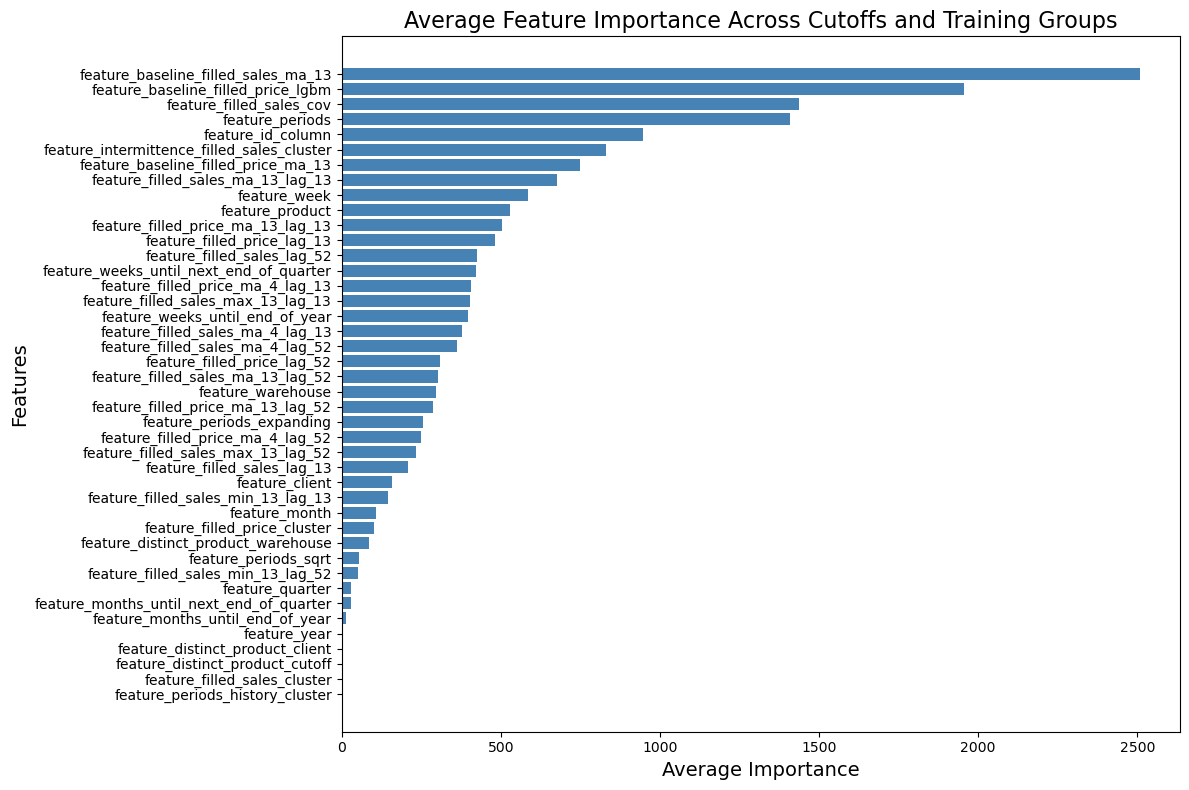

In [19]:
# Plot the average feature importance across all cutoffs
forecaster.plot_feature_importance()

## Run evaluator

In [20]:
# Params
actuals_col = 'sales'
baseline_col = 'baseline_filled_sales_ma_13'
preds_col = ['prediction']

# Initialize the Evaluator class
evaluator = Evaluator(df_with_preds, actuals_col, baseline_col, preds_col)

# Call the function
metric_table = evaluator.create_metric_table()

# Show
metric_table

RMSE    MAE    MAPE  WMAPE  Custom Metric
baseline_filled_sales_ma_13  72.31  25.69  137.92  60.94          88.42
prediction                   62.16  21.94  128.24  52.04          70.96

## Lag metrics

In [21]:
# Params
metric_name = 'WMAPE'
group_col = 'fcst_lag'

# Call the function
lag_metrics = evaluator.calculate_grouped_metric(metric_name, group_col)

# Show
lag_metrics

fcst_lag         1.0        2.0        3.0        4.0        5.0        6.0   \
Baseline    50.261056  54.429345  60.210325  57.636170  56.524259  60.384547   
prediction  38.465512  41.980099  50.284864  48.513182  48.576432  50.744951   

fcst_lag         7.0        8.0        9.0        10.0       11.0       12.0  \
Baseline    61.182713  65.935685  58.906736  64.014107  66.165539  71.148497   
prediction  52.592635  57.994758  53.150302  55.664021  57.257905  63.786528   

fcst_lag         13.0      14.0       15.0       16.0       17.0       18.0  
Baseline    66.648421  65.55548  71.232658  71.969110  71.281933  62.312977  
prediction  58.634390  59.99610  61.657153  62.714658  62.298904  60.739239

# Plot predictions


In [22]:
# Get the max cutoff
max_cutoff = df_with_preds['cutoff'].max()

# Filter the DataFrame where cutoff is equal to the max cutoff
df_filtered = df_with_preds[df_with_preds['cutoff'] == max_cutoff]

# Show
df_filtered.head()

client  warehouse  product   id_column        date  sales  price  \
2149152       1         79    10446  1/79/10446  2020-07-06    0.0    NaN   
2149153       1         79    13209  1/79/13209  2020-07-06    0.0    NaN   
2149154       1         79    13731  1/79/13731  2020-07-06    0.0    NaN   
2149155       1         79     2289   1/79/2289  2020-07-06    0.0    NaN   
2149156       1         79     2839   1/79/2839  2020-07-06    0.0    NaN   

         filled_sales  filled_price      cutoff sample  feature_client  \
2149152           0.0           NaN  2024-01-01  train               0   
2149153           0.0           NaN  2024-01-01  train               0   
2149154           0.0           NaN  2024-01-01  train               0   
2149155           0.0           NaN  2024-01-01  train               0   
2149156           0.0           NaN  2024-01-01  train               0   

         feature_warehouse  feature_product  feature_id_column  \
2149152                 33               85                577   
2149153                 33              575                620   
2149154                 33              665                629   
2149155                 33              925                648   
2149156                 33             1038                655   

         feature_periods  feature_periods_expanding  feature_periods_sqrt  \
2149152              0.0                        0.0                   0.0   
2149153              0.0                        0.0                   0.0   
2149154              0.0                        0.0                   0.0   
2149155              0.0                        0.0                   0.0   
2149156              0.0                        0.0                   0.0   

         feature_year  feature_quarter  feature_month  feature_week  \
2149152          2020                3              7            28   
2149153          2020                3              7            28   
2149154          2020                3              7            28   
2149155          2020                3              7            28   
2149156          2020                3              7            28   

         feature_weeks_until_next_end_of_quarter  \
2149152                                       12   
2149153                                       12   
2149154                                       12   
2149155                                       12   
2149156                                       12   

         feature_weeks_until_end_of_year  \
2149152                               25   
2149153                               25   
2149154                               25   
2149155                               25   
2149156                               25   

         feature_months_until_next_end_of_quarter  \
2149152                                         2   
2149153                                         2   
2149154                                         2   
2149155                                         2   
2149156                                         2   

         feature_months_until_end_of_year  filled_sales_ma_4  \
2149152                                 5                0.0   
2149153                                 5                0.0   
2149154                                 5                0.0   
2149155                                 5                0.0   
2149156                                 5                0.0   

         filled_sales_ma_13  filled_price_ma_4  filled_price_ma_13  \
2149152                 0.0                NaN                 NaN   
2149153                 0.0                NaN                 NaN   
2149154                 0.0                NaN                 NaN   
2149155                 0.0                NaN                 NaN   
2149156                 0.0                NaN                 NaN   

         filled_sales_min_13  filled_sales_max_13  filled_price_min_13  \
2149152                  0.0         

In [23]:
# Params
baseline_col = 'baseline_filled_sales_ma_13'
top_n_plots = 6

## Plot by client

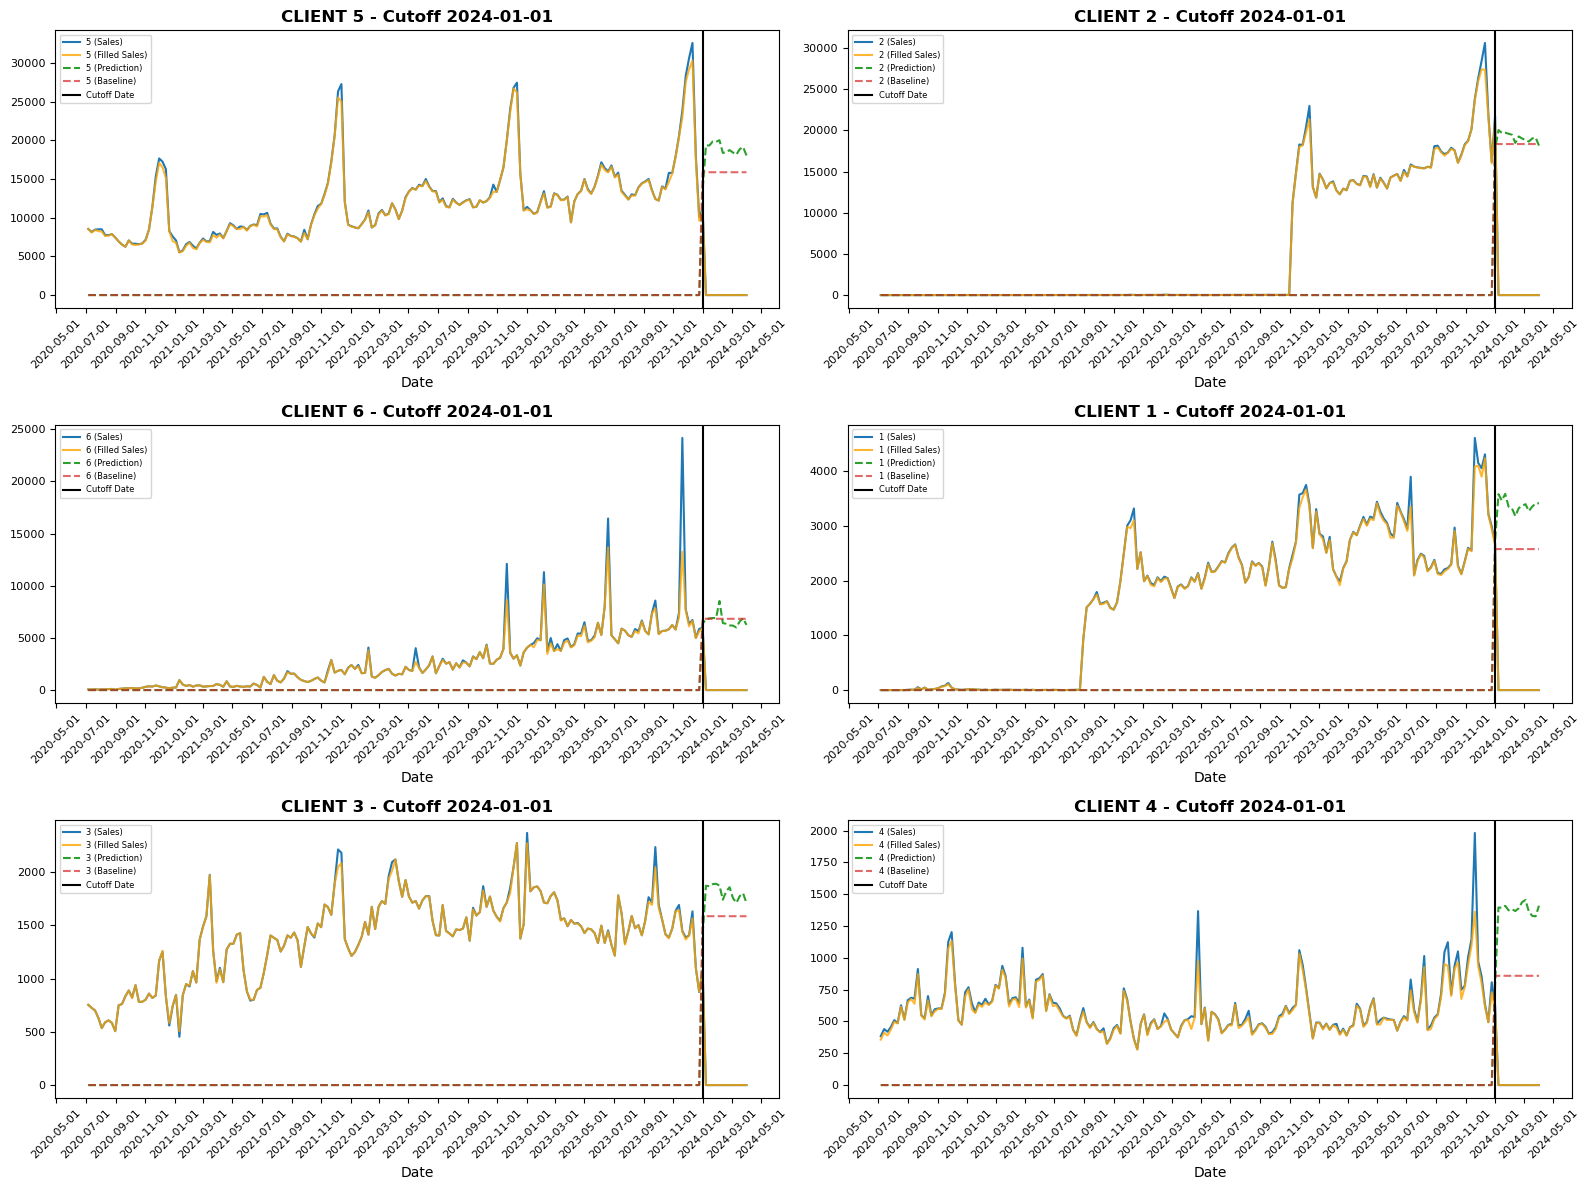

In [24]:
# Plot by client
process_and_plot(
    df_filtered,
    group_col='client',
    baseline_col=baseline_col,
    top_n=top_n_plots,
    title='Top Clients Sales vs Baseline vs Prediction'
)

## Plot by warehouse

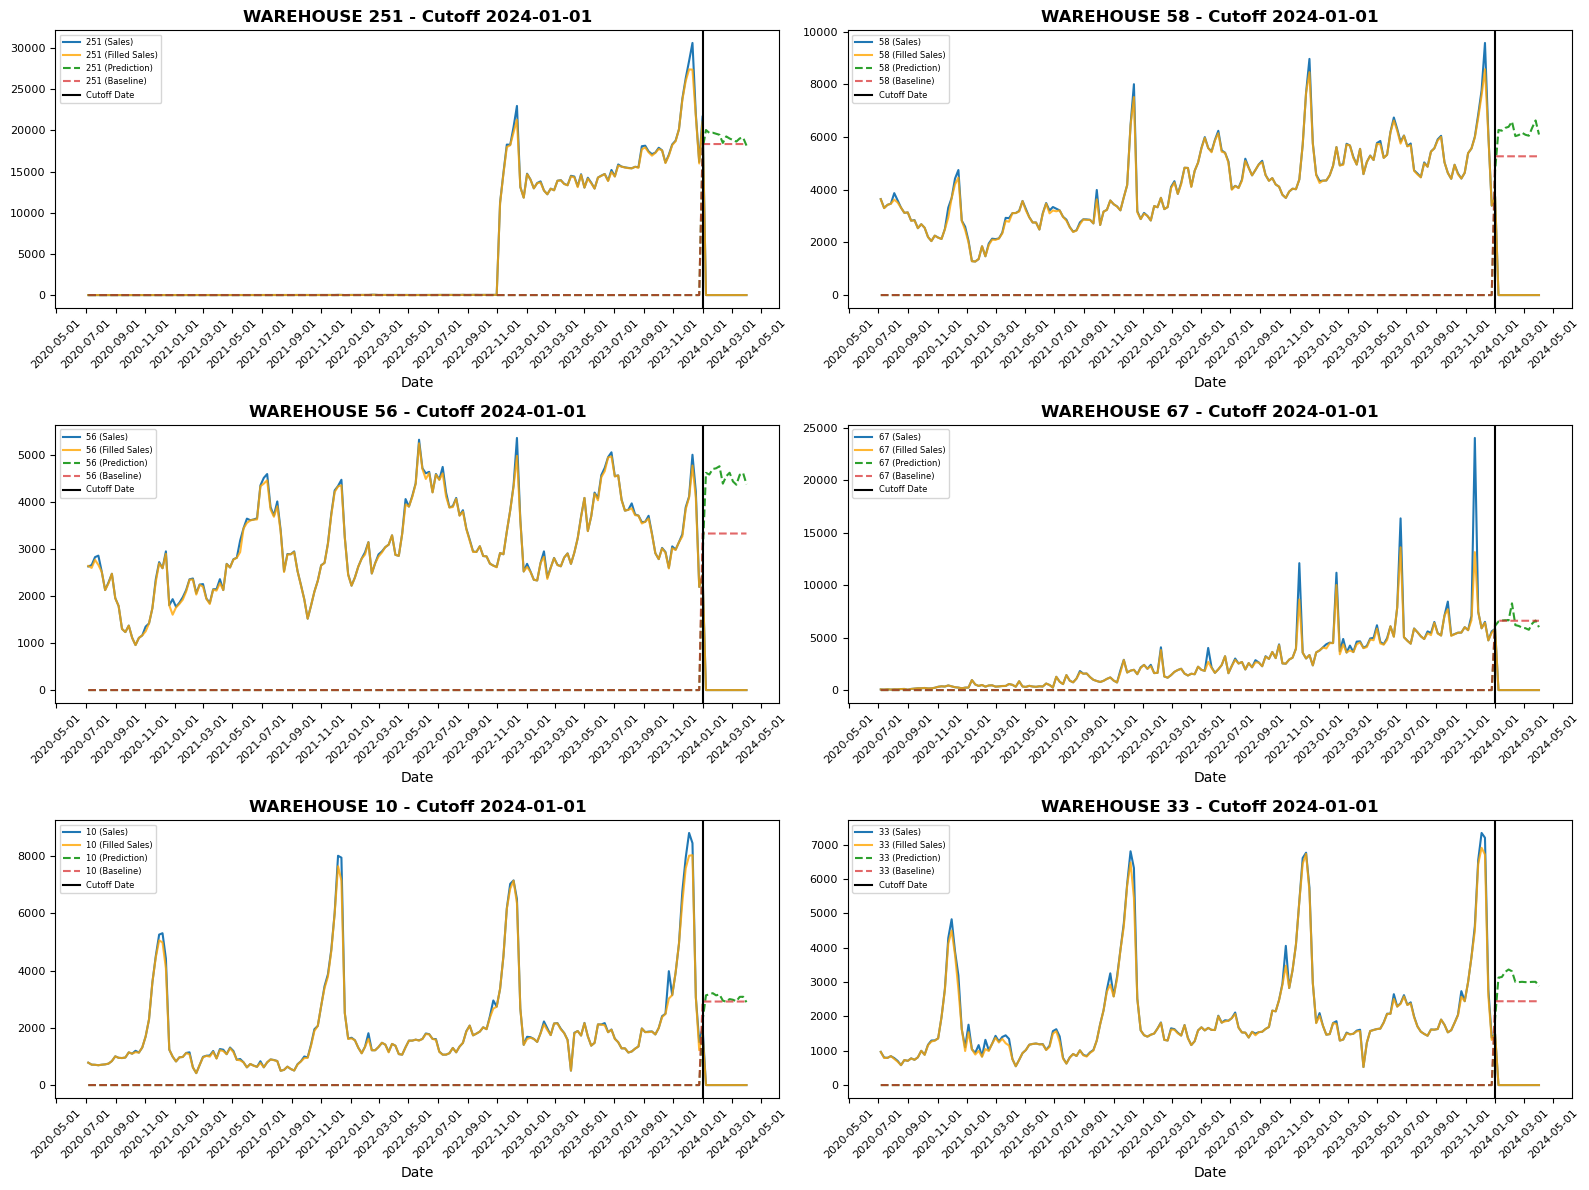

In [25]:
# Plot by warehouse
process_and_plot(
    df_filtered,
    group_col='warehouse',
    baseline_col=baseline_col,
    top_n=top_n_plots,
    title='Top Warehouses Sales vs Baseline vs Prediction'
)

## Plot by Product

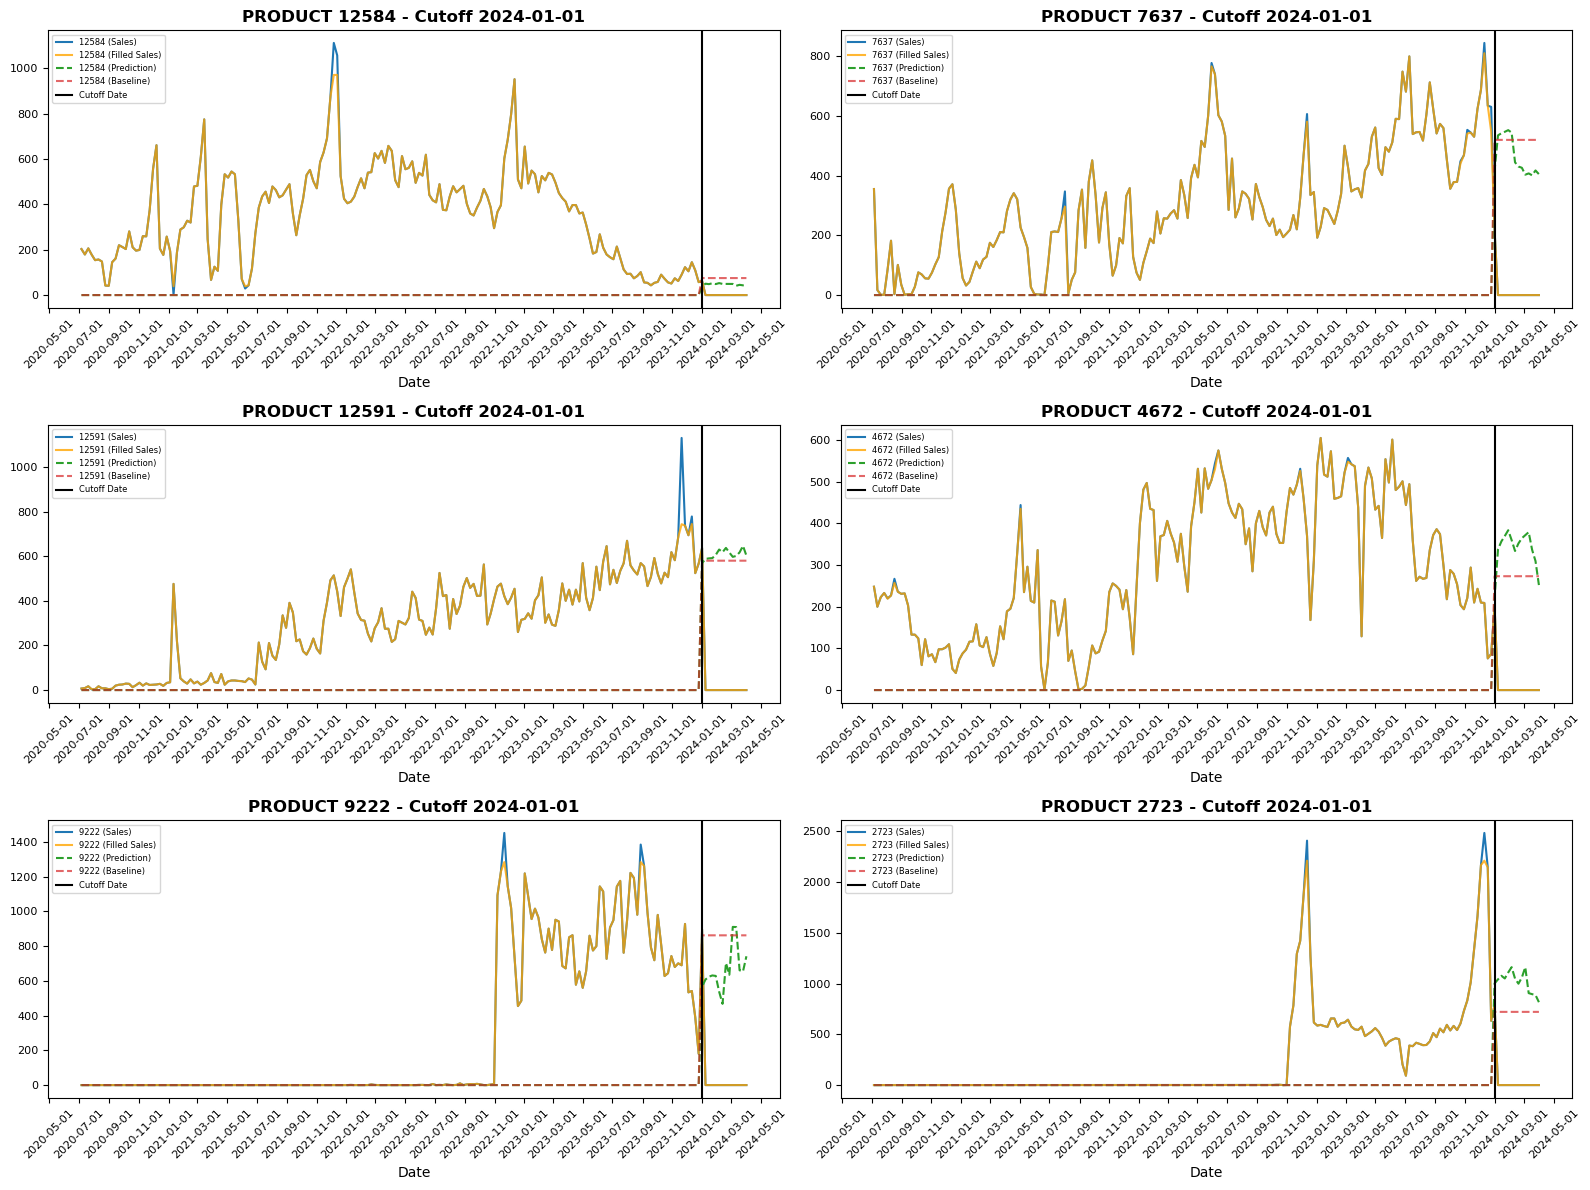

In [26]:
# Plot by product
process_and_plot(
    df_filtered,
    group_col='product',
    baseline_col=baseline_col,
    top_n=top_n_plots,
    title='Top Products Sales vs Baseline vs Prediction'
)

# Save output

In [27]:
# Create the filename with the phase appended
file_name = f'Data/df_lightgbm_preds.csv'

# Write the dataframe to the CSV file
df_with_preds.to_csv(file_name, index=False)

# Clean

In [28]:
# Garbage collection
gc.collect()

31206